# Vending Machine simulator

an effort to make a Monte-Carlo simulator for VM that will help to understand effect of different policies about product selection and refil strategy.

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt

from vmSim import *

# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2


## Future considerations
- [ ] how to punish absense of variaty? 
    - e.g. introduce no_sale parameter that is some percentage for each category of products that is not present in VM that may hit no sale per customer
    - or do customer pick disregarding availability, and if not available then have some % that customer will do another pick
- [ ] cost of trip to refil, base cost of the crew
- [ ] map of locations (graph) with trasport costs b/w them for cost of trip estimate
- [ ] high level strategies: e.g. if one location is due for refill, then refill second in the same trip
- [ ] break downs?

# Some kind of introduction

In [38]:
# is a table with name and confidence interval of popularity
# popularity is just a number, it will later be normalized among all products, so relative is significant, not absolute
# log normal distribution is used to sample

products = {
    'coke': (50, 70),
    'beer': (10, 30),
    'water': (30, 50)
}

{'coke': 54.8841063645119, 'beer': 15.534279393186027, 'water': 39.8630474852917}
[54.8841063645119]


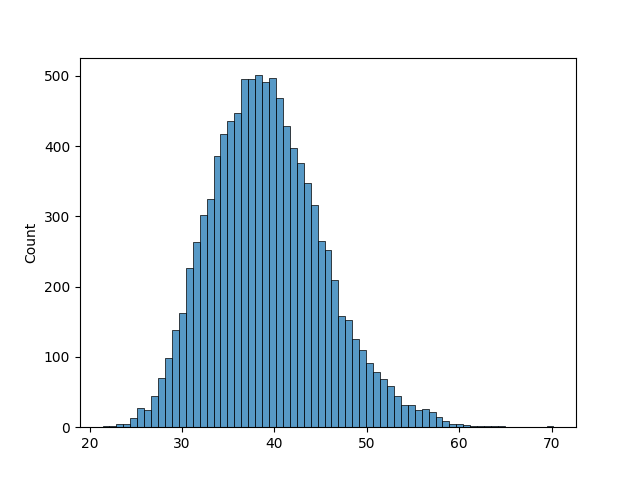

In [39]:
# example of Customer class
# it generates a random customer with preferences based on products popularity
c = Customer(products)
print(c.preferences)
print(c['coke'])

preferences = []
for _ in range(10_000):
    c = Customer(products)
    preferences.append(*c['water'])
    
plt.figure()
sns.histplot(data=np.array(preferences))
plt.show()

In [21]:
local_time = SimulationTime() # basically a counter to keep things sync

In [43]:
# primary attribute of the location is it's traffic that may be random and given by confidence interval
l = Location('Sakh', traffic_CI=(15, 30))
l.visits_today  # generates within confidence interval provided from lognormal distribution

21

In [44]:
columns = {  # name of product, count
    'coke': 20,
    'beer': 10,
}

# currently it's a dict, no definition of columns, but total ammount

In [48]:
# example of VendingMachine class
vm = VendingMachine(name='vm', columns=columns, location=l, time=local_time)
choices = vm.available_products
picked_product = c.pick(choices)
vm.dispense_product(picked_product)
vm.inventory

{'coke': 20, 'beer': 9}

# Simulation main functions

In [21]:
def complete_day_cycle(vm, products):
    for i in range(vm.location.visits_today):
        c = Customer(products)
        picked_product = c.pick(vm.available_products)
        vm.dispense_product(picked_product)

## Refill strategy

In [49]:
# there is base strategy to write and read history if it may be usefull later

class TopupExistingOnMinLevel(BaseStrategy):
    def __init__(self, name, min_level: int, topup: dict):
        self.name = name
        self.min_level = min_level
        self.topup = topup
    
    def make_refil_decision(self, vending_machine: VendingMachine) -> Union[bool, dict]:
        """
        takes state of provided vending machine and makes decision to refill or not
        if refill, returns product-ammount dict
        if not, returns False
        """
        self.vm = vending_machine
        decision = {}
        for name, ammount in vm.columns.items():
            decision[name] = self.topup[name] if ammount < self.min_level else 0
        if sum(decision.values()) == 0: decision = False
        self.write_decision(decision)
        return decision

In [50]:
class FillUpExistingToMaxOnMinLevel(BaseStrategy):
    def __init__(self, name, min_level: int, max_levels: dict):
        self.name = name
        self.min_level = min_level
        self.max_levels = max_levels
    
    def make_refil_decision(self, vending_machine: VendingMachine) -> Union[bool, dict]:
        """
        takes state of provided vending machine and makes decision to refill or not
        if refill, returns product-ammount dict
        if not, returns False
        """
        self.vm = vending_machine
        decision = {}
        for name, ammount in vm.columns.items():
            decision[name] = self.max_levels[name] - ammount if ammount < self.min_level else 0
        if sum(decision.values()) == 0: decision = False
        self.write_decision(decision)
        return decision

# Simulation

## Set up

In [25]:
local_time = SimulationTime()

low_traffic_loc = Location('boring place', traffic_CI=(3, 10))
high_traffic_loc = Location('railroad', traffic_CI=(20, 40))

# -- Products --

PRODUCTS = {
    'papa_beer': (30, 50),
    'mama_beer': (10, 20),
    'baby_beer': (1, 5),
    'water'    : (15, 25),
}

PRODUCTS_COSTS = {
    'papa_beer': 250,
    'mama_beer': 300,
    'baby_beer': 200,
    'water'    : 100,  
}

PRODUCTS_MARGIN = {
    'papa_beer': 70,
    'mama_beer': 100,
    'baby_beer': 150,
    'water'    : 50,  
}


# -- VMs --
vm1 = VendingMachine(name='vm1', location=low_traffic_loc, time=local_time, columns={
    'papa_beer': 40,
    'water'    : 40,
})

vm2 = VendingMachine(name='vm2', location=high_traffic_loc, time=local_time, columns={
    'papa_beer': 40,
    'mama_beer': 20,
    'baby_beer': 10,
    'water'    : 40,
})


VMs = [vm1, vm2]

# -- Strategies -- 
s_topup_low_at_5 = TopupExistingOnMinLevel('top_up_if_less_5', min_level=5, topup={
    'papa_beer': 15,
    'mama_beer': 10,
    'baby_beer': 5,
    'water'    : 15,      
})
s_topup_high_at_10 = TopupExistingOnMinLevel('top_up_if_less_10', min_level=10, topup={
    'papa_beer': 25,
    'mama_beer': 20,
    'baby_beer': 10,
    'water'    : 25,      
})
s_to_max_on_5 = FillUpExistingToMaxOnMinLevel('at 5 to max', min_level=5, max_levels= {
    'papa_beer': 30,
    'mama_beer': 20,
    'baby_beer': 13,
    'water'    : 30,      
})

STGs = {
    vm1: s_to_max_on_5,
    vm2: s_to_max_on_5,
}

## Running cycle

In [60]:
total_inventory_levels = pd.DataFrame(columns=(['day'] + list(PRODUCTS.keys())))
total_inventory_levels.set_index('day')
total_sales = pd.DataFrame(columns=(['day'] + list(PRODUCTS.keys())))
total_sales.set_index('day')
refills_per_day = []
sold_outs_per_day = []

for day in range(10_000):
    local_time.click()
    today_inventory_levels = defaultdict(lambda: 0)
    today_sales = defaultdict(lambda: 0)
    refills_count = 0
    sold_outs_count = 0
    
    for vm in VMs:
        complete_day_cycle(vm, PRODUCTS)
        today_inventory_levels['day'] = local_time.today
        for name, ammount in vm.inventory.items():
            today_inventory_levels[name] += ammount
        
        refil_stategy = STGs[vm]
        refill_data = refil_stategy.make_refil_decision(vm)
        if refill_data:
            vm.refill(refill_data)
            refills_count += 1
        today_sales['day'] = local_time.today
        for name, ammount in vm.today_sales.items():
            today_sales[name] += ammount
        sold_outs_count += vm.today_sold_outs
            
    total_inventory_levels = total_inventory_levels.append(today_inventory_levels, ignore_index=True)
    total_sales = total_sales.append(today_sales, ignore_index=True)  
    refills_per_day.append(refills_count)
    sold_outs_per_day.append(sold_outs_count)

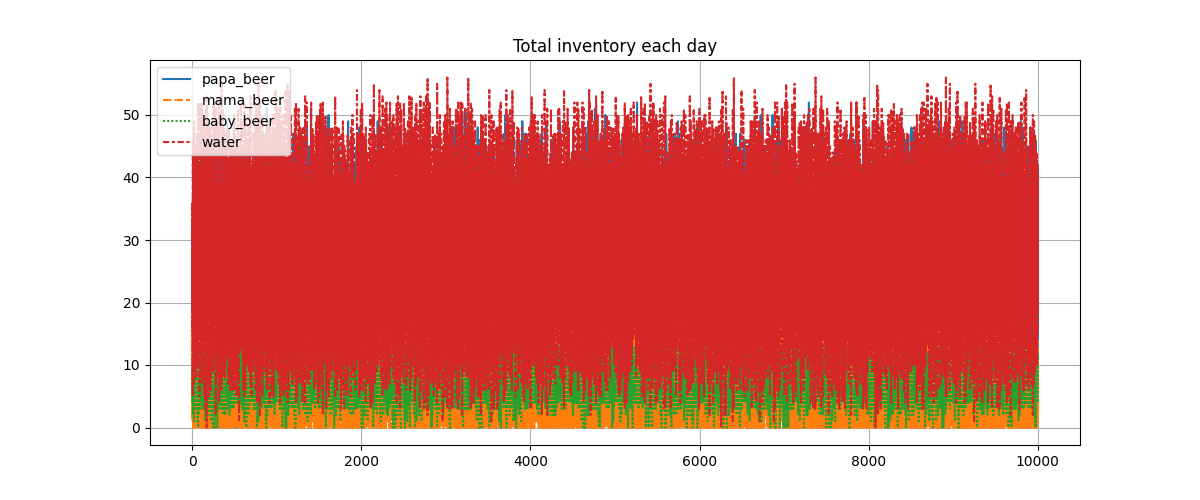

In [61]:
plt.figure(figsize=(12, 5))
plt.grid()
sns.lineplot(data=total_inventory_levels[PRODUCTS.keys()])
plt.title('Total inventory each day')
plt.show()

Average inventory cost per day: 12,479.7 (sigma 3,814.9)


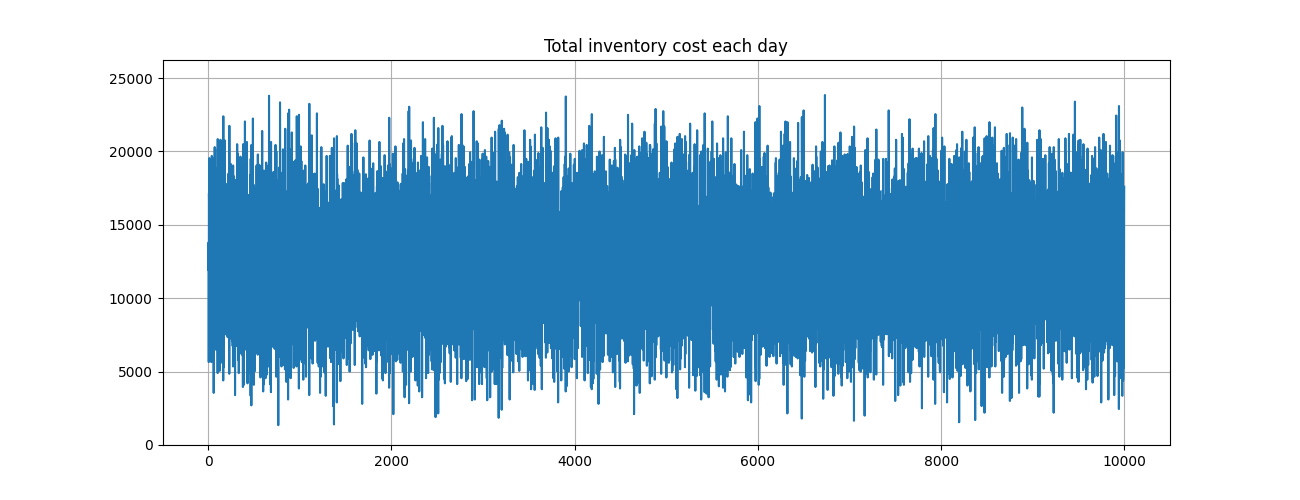

In [62]:
total_inventory_cost = np.dot(total_inventory_levels[PRODUCTS.keys()].values,
       np.array([PRODUCTS_COSTS[product] for product in PRODUCTS.keys()]).reshape(-1, 1))  # this to make sure columns aligned, not just .values

plt.figure(figsize=(13, 5))
plt.grid()
plt.ylim(0, total_inventory_cost.max() * 1.1)
plt.plot(total_inventory_cost)
plt.title('Total inventory cost each day')
plt.plot()
print(f'Average inventory cost per day: {np.mean(total_inventory_cost):,.1f} (sigma {np.std(total_inventory_cost):,.1f})')

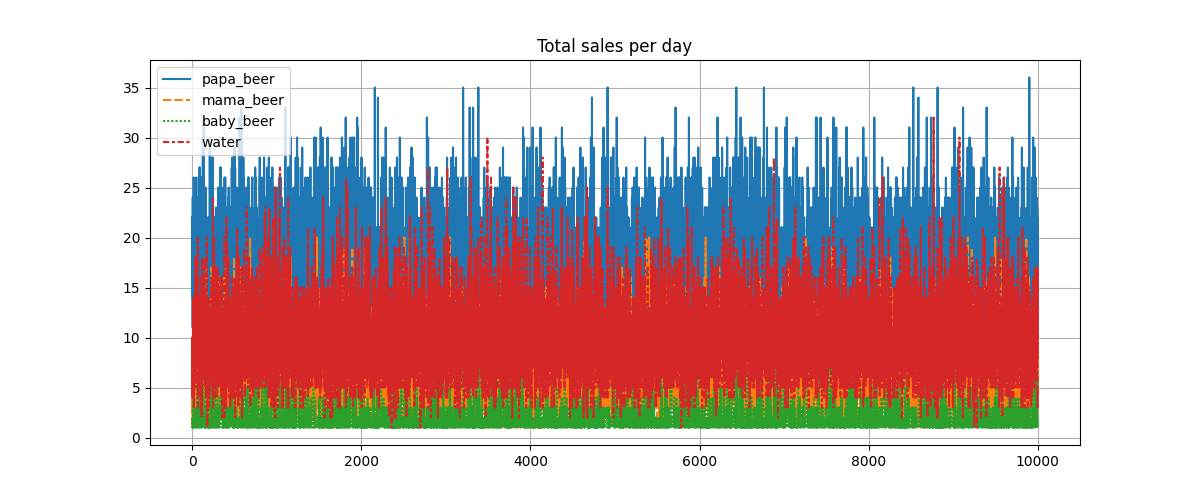

In [63]:
plt.figure(figsize=(12, 5))
plt.grid()
sns.lineplot(data=total_sales[PRODUCTS.keys()])
plt.title('Total sales per day')
plt.show()

Total sold outs for simulations: 6709


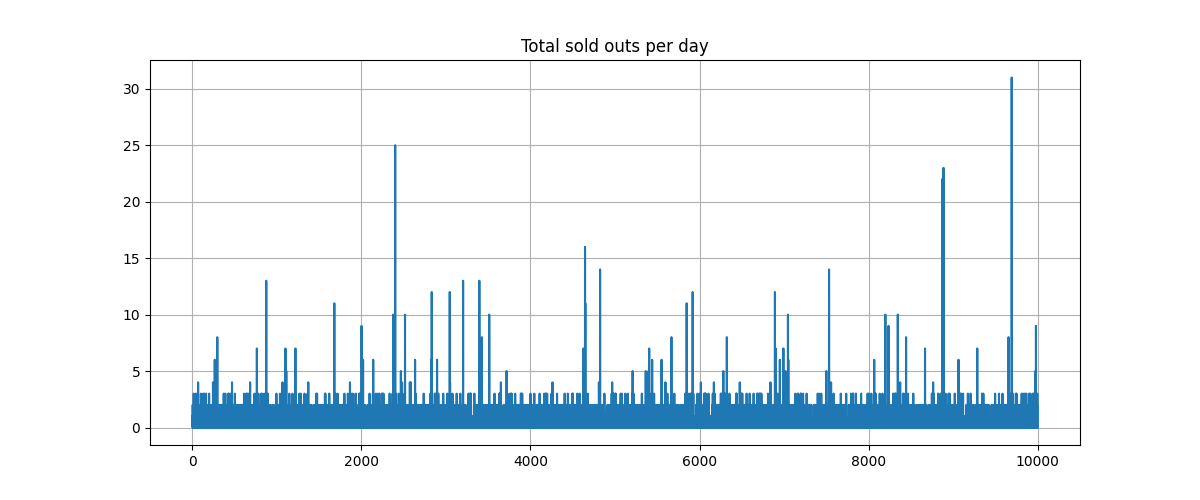

In [64]:
plt.figure(figsize=(12, 5))
plt.grid()
sns.lineplot(data=sold_outs_per_day)
plt.title('Total sold outs per day')
plt.plot()
print(f'Total sold outs for simulations: {sum(sold_outs_per_day)}')

Average profit per day: 2439.2 (sigma 506.2)


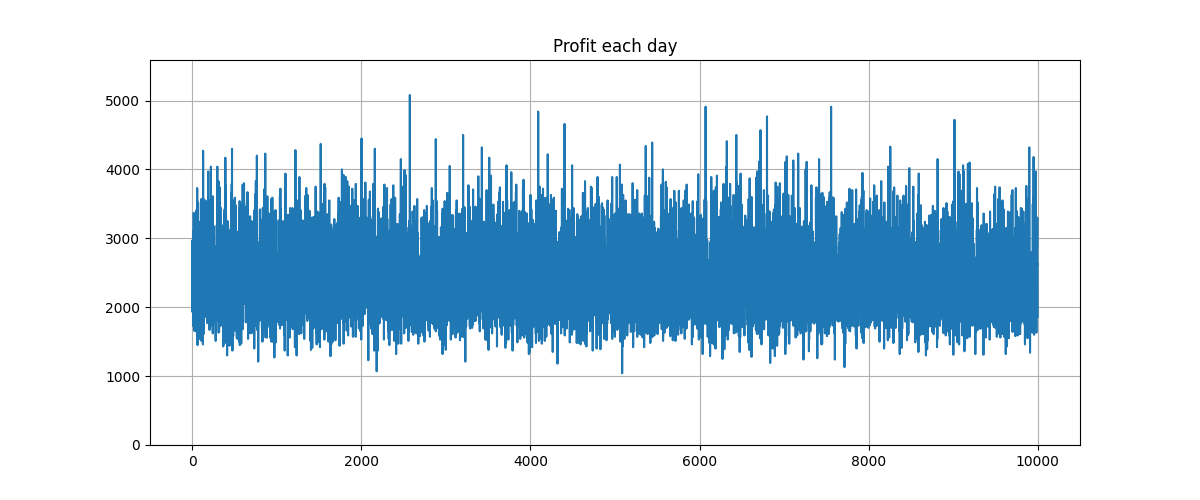

In [65]:
profit = np.dot(total_sales[PRODUCTS.keys()].fillna(0).values,
                np.array([PRODUCTS_MARGIN[product] for product in PRODUCTS.keys()]).reshape(-1, 1))  # this to make sure columns aligned, not just .values

plt.figure(figsize=(12, 5))
plt.grid()
plt.ylim(0, profit.max() * 1.1)
plt.plot(profit)
plt.title('Profit each day')
plt.plot()
print(f'Average profit per day: {np.mean(profit):.1f} (sigma {np.std(profit):.1f})')

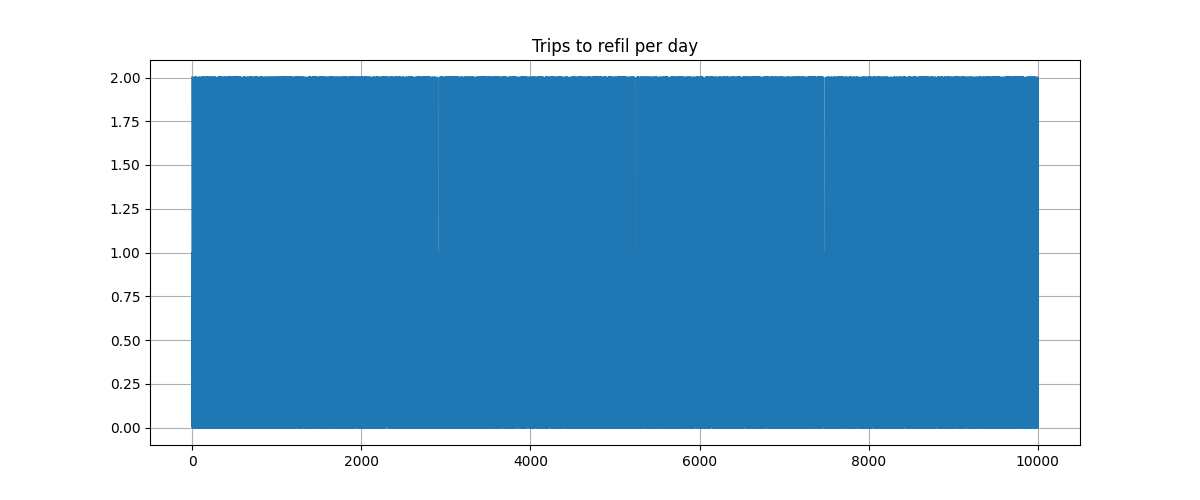

Total top ups for simulations: 9057


In [70]:
plt.figure(figsize=(12, 5))
plt.grid()
plt.plot(refills_per_day)
plt.title('Trips to refil per day')
plt.show()
print(f'Total top ups for simulations: {sum(refills_per_day)}')

## Sort of economic model

In [67]:
interest_rate = 0.03
trip_cost = 500

In [68]:
expenses = sum(refills_per_day) * trip_cost + np.mean(total_inventory_cost)/365 * len(total_inventory_cost) * interest_rate
profits = sum(profit)[0]
1¡revenue = profits - expenses
print(f"{revenue:,.1f} = {profits:,.1f} - {expenses:,.1f}")

19,853,322.7 = 24,392,080.0 - 4,538,757.3


two low top ups:          18,190,756.7 = 24,691,230.0 - 6,500,473.3

two refills to max:       19,753,465.4 = 24,478,850.0 - 4,725,384.6

one low, one high top up: 18,601,456.7 = 24,330,330.0 - 5,728,873.3

In [ ]:
196,197.7 = 244,300.0 - 48,102.3 